In [18]:
import os 
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')


# About

__Author:__ Pat McCornack

__Date:__ December 2024

__Description:__  
This notebook preprocesses the data and does basic qc checks. This includes subsetting the variables, renaming the variables to a standard format, and taking the action specified in the finding summary. 

__Findings Summary:__  
There's a number of observations with missing timestamps. The entire record is missing for each of these. There's a small number of observations missing for most variables. All missing observations were dropped. Leaf wetness is available, but was found to potentially be unreliable and is not included in this analysis. The same applies to solar radiation. Relative humidity values that were above 100% were set to 100%. 

__Outputs:__  
Cleaned data is output to `./data/02-clean/sci-sauc-clean-2003-2008.csv`. 

In [19]:
def agg_time(df):
    """
    Create datetime stamp using separate Month, Day, Hour, Miunute columns. 

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame to create datetime column for. 

    Returns
    -------
    pandas.DataFrame
        Dataframe with the new 'time (PST)' column, sorted by the 'time (PST)' column. 

    """
    times = []

    if 'Minute' in df.columns:
        for index, row in df.iterrows():
            times.append(f"{str(row['Year']).split('.')[0]}-{str(row['Month']).split('.')[0]}-{str(row['Day']).split('.')[0]} {str(row['Hour']).split('.')[0]}:{str(row['Minute']).split('.')[0]}:00")
    
    elif 'minute' in df.columns:
        for index, row in df.iterrows():
            times.append(f"{str(row['year']).split('.')[0]}-{str(row['month']).split('.')[0]}-{str(row['day']).split('.')[0]} {str(row['hour']).split('.')[0]}:{str(row['minute']).split('.')[0]}:00")

    else:
        for index, row in df.iterrows():
            times.append(f"{str(row['year']).split('.')[0]}-{str(row['month']).split('.')[0]}-{str(row['day']).split('.')[0]} {str(row['hour']).split('.')[0]}:{str(00).split('.')[0]}:00")
   
    df['time (PST)'] = pd.to_datetime(times)
    df = df.sort_values(by='time (PST)', ascending=True)

    return df

## Data QC 

In [20]:
# Specify parameters
# Options
process_time = True  # Does the data have a 'time (PST)' column already, or separate columns for 'month', 'day', etc. 

In [21]:
#### Specify Arguments ###
fname1 = 'sci-upem-2005-2010.csv'
fname2 = 'sci-upem-july-sept-2010.csv'
fname3 = 'sci-upem-june-oct-2011.csv'

root_dir = Path().resolve().parents[1]
data_dir = root_dir / 'data'
src_fpath1 = data_dir / '01-raw' / 'met-station' / fname1
src_fpath2 = data_dir / '01-raw' / 'met-station' / fname2
src_fpath3 = data_dir / '01-raw' / 'met-station' / fname3

outfpath = data_dir / '02-clean' / f'sci-upem-clean.csv'


# Define variables
var_dict1 = {
    'time (PST)' : 'time (PST)',
    'fog' :'Fog_Vol_mL',
    'air temperature (C)' : 'AirTC_Avg',
    'relative humidity (%)' : 'RH_Avg',
    'wind speed (m/s)' : 'WS_ms_Avg',
    'wind gust (m/s)' : 'WS_ms_Max',
    'wind direction (deg)' : 'WS_ms_WVc(2)',  # Not certain this is wind dir - see distribution
    'rain (mm)' : 'Rain_Converted_mm',  # Unsure about units
    'solar radiation (kwm2)' :'SlrkW_Avg'
}

var_dict2 = {
    'time (PST)' : 'time (PST)',
    'fog' :'fog_vol_ml',
    'air temperature (C)' : 'airtc_avg',
    'relative humidity (%)' : 'rh_avg',
    'wind speed (m/s)' : 'ws_ms_avg',
    'rain (mm)' : 'rain_converted_mm'
}

var_dict3 = {
    'time (PST)' : 'time (PST)',
    'fog' :'fog_ml',
    'air temperature (C)' : 'temp',
    'relative humidity (%)' : 'rh',
    'rain (mm)' : 'rain_mm'
}
# Fog tip value
fog_tip_v = 3.7253

In [22]:
#### Read in and prepare data ####
df1 = pd.read_csv(src_fpath1)
df2 = pd.read_csv(src_fpath2)
df3 = pd.read_csv(src_fpath3)

# Create single datetime column
df1 = agg_time(df1)
df2 = agg_time(df2)
df3 = agg_time(df3)

# Subset and rename columns
df1 = df1[list(var_dict1.values())]
df1.columns = list(var_dict1.keys())

df2 = df2[list(var_dict2.values())]
df2.columns = list(var_dict2.keys())

df3 = df3[list(var_dict3.values())]
df3.columns = list(var_dict3.keys())

# Join the dataframes
df = pd.concat([df1, df2, df3], join='outer', axis=0)

# Create fog tip var
df['fog tips'] = df['fog'] / fog_tip_v
    
df.head(3)

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),solar radiation (kwm2),fog tips
53189,2005-09-15 15:15:00,NaN,15.98,74.25,2.309,3.180,240.6,NaN,NaN,NaN
53190,2005-09-15 15:30:00,NaN,15.55,75.94,2.649,3.481,245.7,NaN,NaN,NaN
53191,2005-09-15 15:45:00,NaN,15.27,77.03,2.896,3.490,249.4,NaN,NaN,NaN


### Missing Values
Observations:
1. ~~Leaf wetness is missing around a quarter of values~~ - no longer included in set of variables. 
2. ~~Solar radiation is missing around a quarter of observations.~~ - lo longer included in set of variables.
4. There's a small number of missing observations for most variables. 

Actions:
1. Drop rows with missing fog data


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157763 entries, 53189 to 11803
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   time (PST)              157763 non-null  datetime64[ns]
 1   fog                     145275 non-null  float64       
 2   air temperature (C)     157763 non-null  float64       
 3   relative humidity (%)   157763 non-null  float64       
 4   wind speed (m/s)        145959 non-null  float64       
 5   wind gust (m/s)         137674 non-null  float64       
 6   wind direction (deg)    137674 non-null  float64       
 7   rain (mm)               145275 non-null  float64       
 8   solar radiation (kwm2)  132118 non-null  float64       
 9   fog tips                145275 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 13.2 MB


In [24]:
df.dropna(subset='fog', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145275 entries, 2835 to 11803
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   time (PST)              145275 non-null  datetime64[ns]
 1   fog                     145275 non-null  float64       
 2   air temperature (C)     145275 non-null  float64       
 3   relative humidity (%)   145275 non-null  float64       
 4   wind speed (m/s)        133471 non-null  float64       
 5   wind gust (m/s)         125186 non-null  float64       
 6   wind direction (deg)    125186 non-null  float64       
 7   rain (mm)               145275 non-null  float64       
 8   solar radiation (kwm2)  125186 non-null  float64       
 9   fog tips                145275 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 12.2 MB


### Univariate Distributions

Check boxplots of each variable to assess data quality.

Observations:
1. Relative humidity is typically high at the site. 
2. Wind typically comes from the northwest, but has a higher spread than pozo.  
3. Most fog observations are 0 - this skews the distribution.
4. There are RH values above 100. 
5. ~~It looks like the pyranometer values are probably in w/m2~~ Not currently using pyranometer. 

Actions
1. Set observations where RH is above 100 to 100. 
2. Check the observations where RH is 0. 
3. Look closer at the distribution of the fog values.
4. ~~Correct solar radiation to represent kw/m2.~~ Not currently using pyranometer values. 

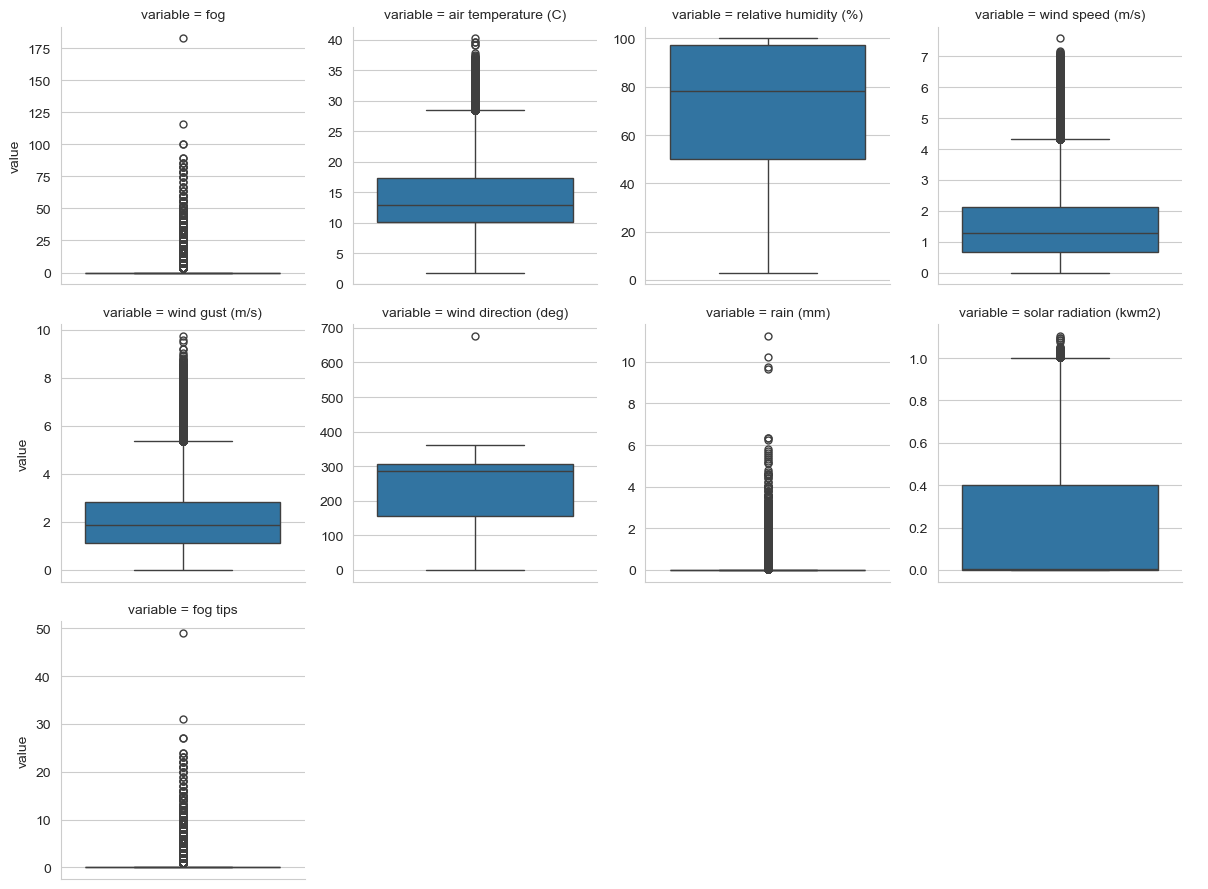

In [25]:
#### Quick plot of distributions ####
# Create long form data
value_col = df.columns.drop(['time (PST)']).tolist()
df_long = pd.melt(df, id_vars=['time (PST)'], value_vars=value_col)

# Plot boxplots
sns.catplot(data=df_long, kind='box', col='variable', y='value',
            sharey=False, height=3, col_wrap=4)
plt.show()


In [26]:
#### Check the actual values ####
df.describe()

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),solar radiation (kwm2),fog tips
count,145275,145275.000000,145275.000000,145275.000000,133471.000000,125186.000000,125186.000000,145275.000000,125186.000000,145275.000000
mean,2008-08-05 06:01:50.601962240,0.624557,14.066559,70.394784,1.535035,2.136042,239.288857,0.013375,0.209880,0.167653
min,2006-01-30 13:00:00,0.000000,1.847000,3.014000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2007-03-10 02:07:30,0.000000,10.050000,49.955000,0.672000,1.134000,155.000000,0.000000,0.000000,0.000000
50%,2008-08-20 02:45:00,0.000000,12.960000,78.130000,1.291000,1.872000,285.600000,0.000000,0.006000,0.000000
75%,2009-09-02 10:22:30,0.000000,17.390000,97.100000,2.135000,2.834000,305.100000,0.000000,0.401000,0.000000
max,2011-10-01 23:00:00,182.540000,40.180000,100.000000,7.583000,9.750000,677.000000,11.245000,1.105000,49.000081
std,NaN,3.278106,5.507893,28.327516,1.122546,1.328249,93.697301,0.149986,0.299534,0.879958


### Constrain RH to 0-100

In [27]:
df['relative humidity (%)'] = df['relative humidity (%)'].clip(lower=0, upper=100)

### Fog Check
Given the focus of further analysis on fog at the site, further check the distribution of fog.

Observations:
1. Nothing of note, the distribution is as expected. 


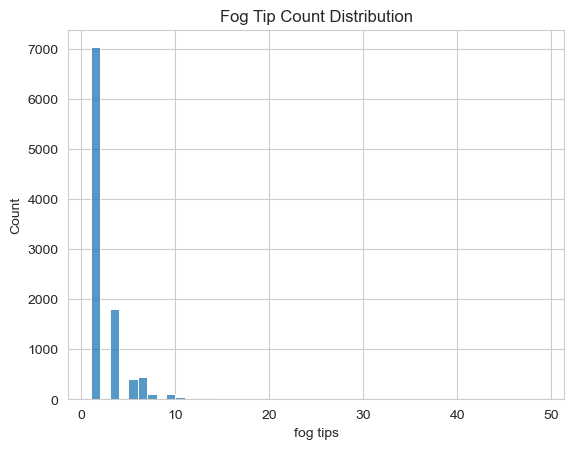

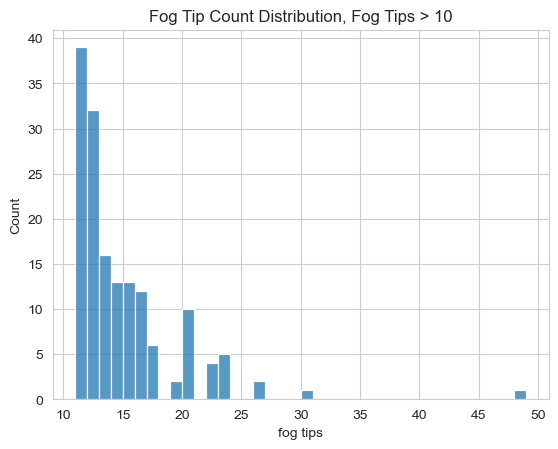

In [28]:
#### Check Distribution of Fog Values ####
sns.histplot(df['fog tips'].loc[df['fog tips']>0],
             binwidth=1)
plt.title('Fog Tip Count Distribution')
plt.show()

# Check right tail of distribution
sns.histplot(df['fog tips'].loc[df['fog tips']>10],
             binwidth=1)
plt.title('Fog Tip Count Distribution, Fog Tips > 10')
plt.show()

### Save out cleaned data

In [30]:
df.to_csv(outfpath)
outfpath

PosixPath('/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis/data/02-clean/sci-upem-clean.csv')